# Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DATASET EXTRACTION
# 1. Ensure you have 'Data.zip' uploaded to your Google Drive.
# 2. Update the path below to point to your zip file location.
# 3. If running locally, skip this cell and manually extract your files into a 'Data' folder.

# Update this path to the location of your uploaded Data.zip
# DRIVE_ZIP_PATH = '/content/drive/MyDrive/CDC_Project/Data.zip'
# Update this to your desired destination folder
# DESTINATION_FOLDER = '/content/drive/MyDrive/CDC_Project/'

# !unzip -q "{DRIVE_ZIP_PATH}" -d "{DESTINATION_FOLDER}"

# print("Extraction complete. Data is ready for processing.")

!unzip /content/drive/MyDrive/CDC_Project/Data.zip -d /content/drive/MyDrive/CDC_Project/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137800085.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137800310.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137900320.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137900410.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137900490.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137910360.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137950350.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137950460.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137950720.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137960110.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137970210.png  
  inflating: /content/drive/MyDrive/

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

In [ ]:
# Change base path
BASE_PATH = "/content/drive/MyDrive/CDC_Project/Data"

TRAIN_CSV = f"{BASE_PATH}/train.csv"
TEST_CSV  = f"{BASE_PATH}/test.csv"

TRAIN_IMAGE_DIR = f"{BASE_PATH}/Images/Train"
TEST_IMAGE_DIR  = f"{BASE_PATH}/Images/Test"

In [4]:
print(os.path.exists(TRAIN_CSV))
print(os.path.exists(TEST_CSV))

df = pd.read_csv(TRAIN_CSV)
print(df.shape)

print("Train images:", len(os.listdir(TRAIN_IMAGE_DIR)))
print("Test images:", len(os.listdir(TEST_IMAGE_DIR)))

True
True
(16209, 21)
Train images: 16110
Test images: 5396


In [5]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

## EDA on Tabular Data

In [6]:
train_df.isnull().sum()

,0
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

In [8]:
KEY_FEATURES = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "lat",
    "long"
]

train_df = train_df[["id", "price"] + KEY_FEATURES]

In [9]:
train_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,lat,long
count,1.620900e+04,1.620900e+04,16209.00000,16209.000000,16209.000000,16209.000000,16209.000000
mean,4.575771e+09,5.374703e+05,3.36782,2.113054,2073.274601,47.560707,-122.214003
std,2.874661e+09,3.603036e+05,0.93327,0.765242,907.009491,0.138340,0.140093
min,1.000102e+06,7.500000e+04,0.00000,0.000000,290.000000,47.159300,-122.519000
25%,2.123049e+09,3.200000e+05,3.00000,1.500000,1430.000000,47.472500,-122.328000
50%,3.904950e+09,4.500000e+05,3.00000,2.250000,1910.000000,47.572400,-122.230000
75%,7.304301e+09,6.400000e+05,4.00000,2.500000,2550.000000,47.678200,-122.125000
max,9.900000e+09,7.700000e+06,33.00000,8.000000,12050.000000,47.777600,-121.315000


## Price Distribution

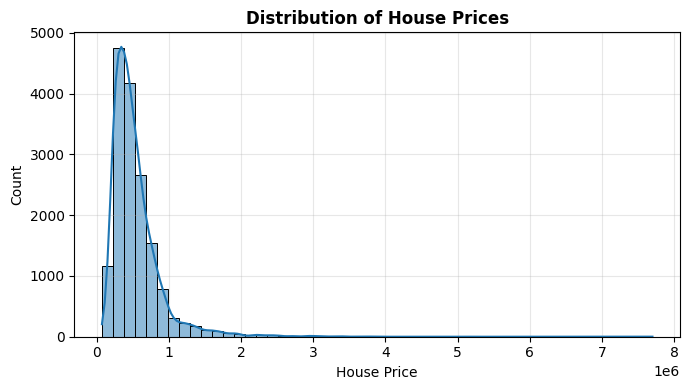

In [10]:
plt.figure(figsize=(7, 4))
sns.histplot(
    train_df["price"],
    bins=50,
    kde=True
)
plt.title("Distribution of House Prices", fontsize=12, fontweight="bold")
plt.xlabel("House Price", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

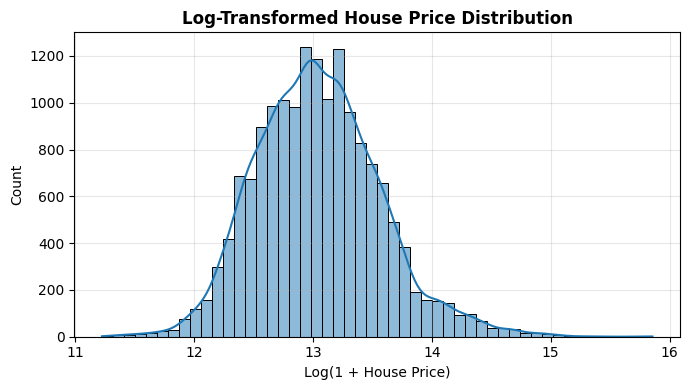

In [11]:
plt.figure(figsize=(7, 4))
sns.histplot(
    np.log1p(train_df["price"]),
    bins=50,
    kde=True
)

plt.title("Log-Transformed House Price Distribution", fontsize=12, fontweight="bold")
plt.xlabel("Log(1 + House Price)", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Relationship with Key Features

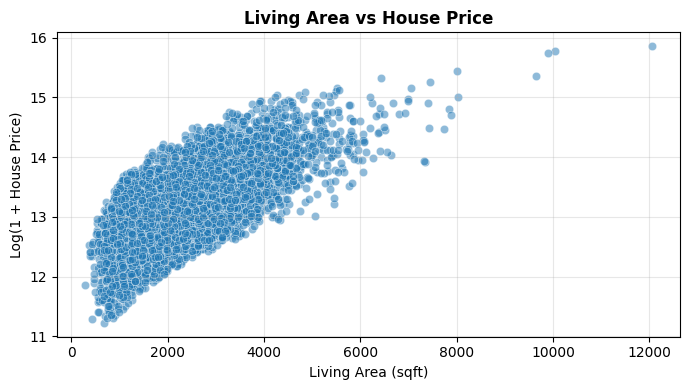

In [12]:
plt.figure(figsize=(7, 4))
sns.scatterplot(
    x="sqft_living",
    y=np.log1p(train_df["price"]),
    data=df,
    alpha=0.5
)

plt.title("Living Area vs House Price", fontsize=12, fontweight="bold")
plt.xlabel("Living Area (sqft)")
plt.ylabel("Log(1 + House Price)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

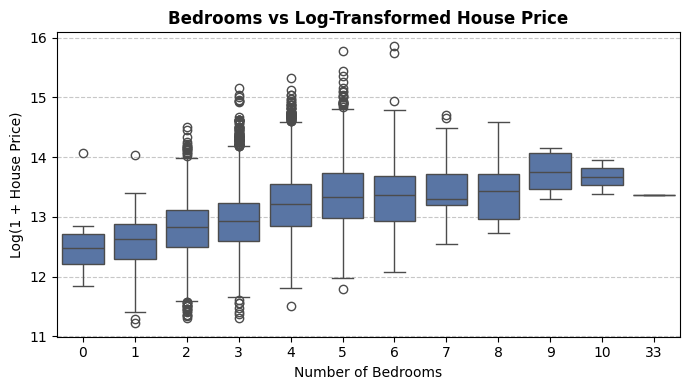

In [13]:
plt.figure(figsize=(7, 4))
sns.boxplot(
    x="bedrooms",
    y=np.log1p(train_df["price"]),
    data=df,
    color="#4C72B0",
    showfliers=True
)

plt.title("Bedrooms vs Log-Transformed House Price", fontsize=12, fontweight="bold")
plt.xlabel("Number of Bedrooms", fontsize=10)
plt.ylabel("Log(1 + House Price)", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

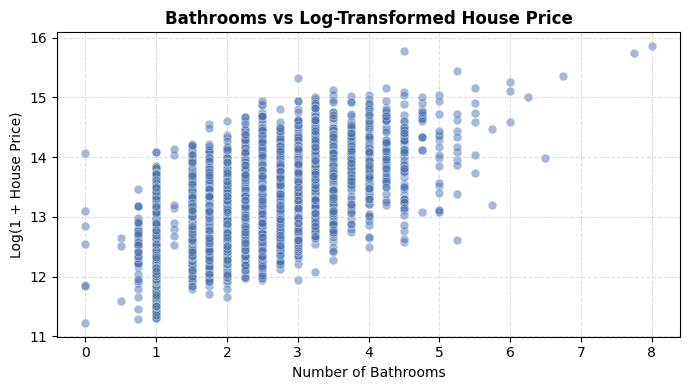

In [14]:
plt.figure(figsize=(7, 4))

sns.scatterplot(
    x="bathrooms",
    y=np.log1p(train_df["price"]),
    data=df,
    color="#4C72B0",
    alpha=0.5,
    s=40
)

plt.title("Bathrooms vs Log-Transformed House Price", fontsize=12, fontweight="bold")
plt.xlabel("Number of Bathrooms", fontsize=10)
plt.ylabel("Log(1 + House Price)", fontsize=10)

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

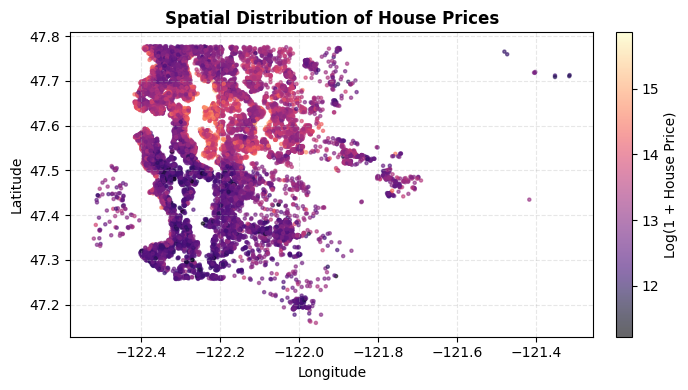

In [15]:
plt.figure(figsize=(7, 4))

scatter = plt.scatter(
    train_df["long"],
    train_df["lat"],
    c=np.log1p(train_df["price"]),
    cmap="magma",
    s=5,
    alpha=0.6
)

cbar = plt.colorbar(scatter, fraction=0.046, pad=0.04)
cbar.set_label("Log(1 + House Price)", fontsize=10)

plt.title("Spatial Distribution of House Prices", fontsize=12, fontweight="bold")
plt.xlabel("Longitude", fontsize=10)
plt.ylabel("Latitude", fontsize=10)
plt.grid(linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


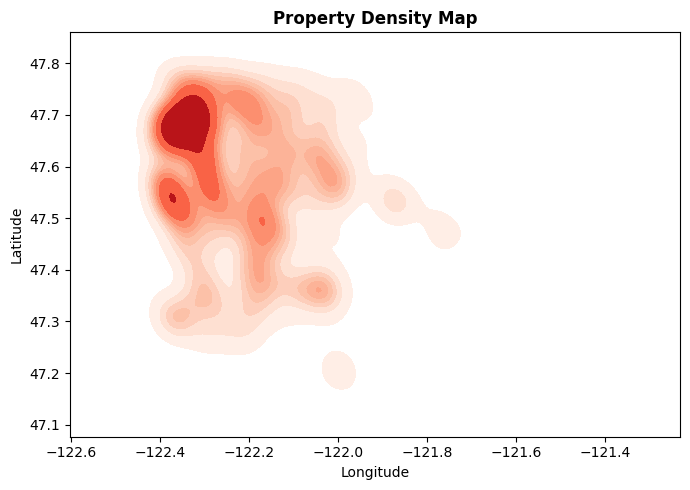

In [16]:
plt.figure(figsize=(7, 5))
sns.kdeplot(
    x=train_df["long"],
    y=train_df["lat"],
    fill=True,
    cmap="Reds",
    thresh=0.05
)
plt.title("Property Density Map", fontsize=12, fontweight="bold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

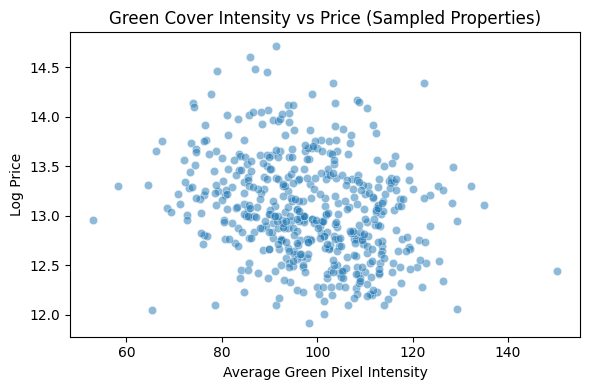

In [18]:
SAMPLE_SIZE = 500

sample_df = train_df.sample(SAMPLE_SIZE, random_state=42)

def green_intensity(img_path):
    img = np.array(Image.open(img_path))
    return img[:, :, 1].mean()

sample_df["green_score"] = sample_df["id"].apply(
    lambda x: green_intensity(
        os.path.join(TRAIN_IMAGE_DIR, f"{int(x)}.png")
    )
)

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=sample_df["green_score"],
    y=np.log1p(sample_df["price"]),
    alpha=0.5
)
plt.title("Green Cover Intensity vs Price (Sampled Properties)")
plt.xlabel("Average Green Pixel Intensity")
plt.ylabel("Log Price")
plt.tight_layout()
plt.show()

## Baseline Model

In [ ]:
X = train_df[KEY_FEATURES]
y = np.log1p(train_df["price"])
ids = train_df["id"]

In [ ]:
X_train, X_val, y_train, y_val, id_train, id_val = train_test_split(
    X, y, ids,
    test_size=0.2,
    random_state=42
)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2_lr = r2_score(y_val, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R2:", r2_lr)

Linear Regression RMSE: 0.3052164207843441
Linear Regression R2: 0.6624177660715089


In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R2:", r2_rf)

Random Forest RMSE: 0.2063268768846079
Random Forest R2: 0.8457321590849585


In [ ]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)

rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2_xgb = r2_score(y_val, y_pred_xgb)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R2:", r2_xgb)

XGBoost RMSE: 0.20039615135184605
XGBoost R2: 0.8544733454715037


## Visualisation of Sample Images

In [ ]:
sample_df = train_df.sample(6, random_state=42)
sample_df[["id", "price"]]

,id,price
4226,1853200190,612000
11070,121059147,392000
2450,123039176,399888
1493,1862400518,385000
3894,3622059155,235000
1163,9512200420,390000


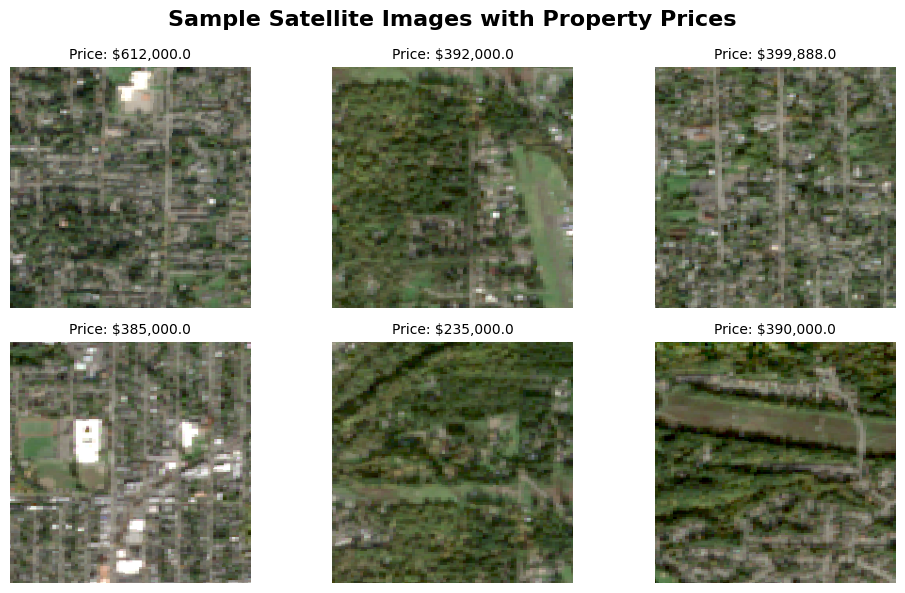

In [ ]:
IMAGE_DIR = f"{BASE_PATH}/Images/Train"

plt.figure(figsize=(10, 6))

for i, (_, row) in enumerate(sample_df.iterrows()):
    img_id = str(int(row["id"]))
    img_path = os.path.join(IMAGE_DIR, f"{img_id}.png")

    img = Image.open(img_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Price: ${row['price']:,}", fontsize=10)

plt.suptitle("Sample Satellite Images with Property Prices", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:
cheap = train_df.nsmallest(3, "price")
expensive = train_df.nlargest(3, "price")

compare_df = pd.concat([cheap, expensive]).reset_index(drop=True)
compare_df

,id,price,bedrooms,bathrooms,sqft_living,lat,long
0,3421079032,75000,1,0.00,670,47.2638,-121.906
1,8658300340,80000,1,0.75,430,47.6499,-121.909
2,3028200080,81000,2,1.00,730,47.4808,-122.315
3,6762700020,7700000,6,8.00,12050,47.6298,-122.323
4,9808700762,7062500,5,4.50,10040,47.6500,-122.214
5,9208900037,6885000,6,7.75,9890,47.6305,-122.240


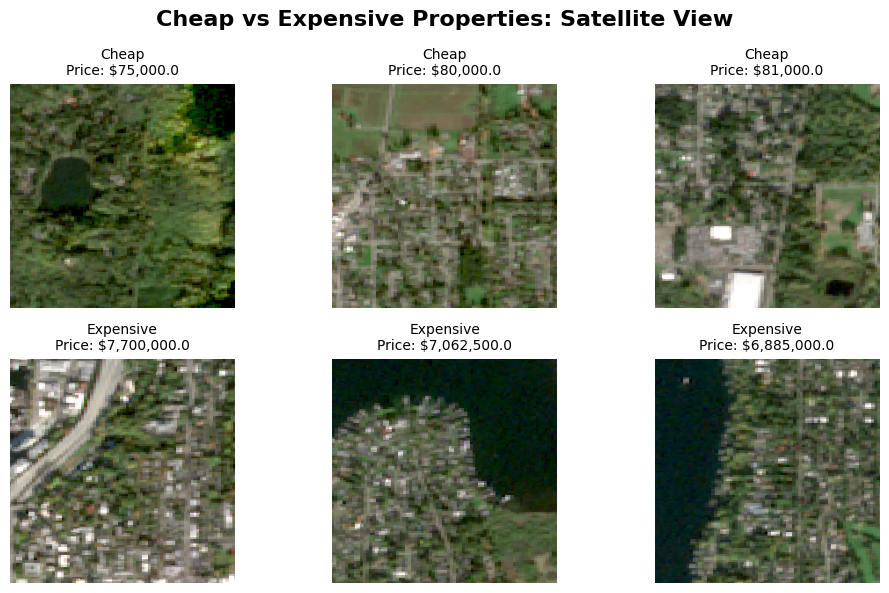

In [ ]:
plt.figure(figsize=(10, 6))

for i, (_, row) in enumerate(compare_df.iterrows()):
    img_id = str(int(row["id"]))
    img_path = os.path.join(IMAGE_DIR, f"{img_id}.png")

    img = Image.open(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

    label = "Cheap" if i < 3 else "Expensive"
    plt.title(f"{label}\nPrice: ${row['price']:,}", fontsize=10)

plt.suptitle(
    "Cheap vs Expensive Properties: Satellite View",
    fontsize=16,
    fontweight="bold"
)
plt.tight_layout()
plt.show()

## Embeddings Generation Using ResNet50

In [ ]:
EMB_DIR = f"{BASE_PATH}/Embeddings"
os.makedirs(EMB_DIR, exist_ok=True)

In [ ]:
resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(224, 224, 3)
)

resnet.trainable = False

print("ResNet50 loaded")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 loaded


In [ ]:
def extract_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))

    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    emb = resnet.predict(img_array, verbose=0)
    return emb.squeeze()

In [ ]:
def generate_embeddings(csv_path, image_dir, split_name):
    df = pd.read_csv(csv_path)

    emb_rows = []
    missing = 0

    print(f"\nExtracting {split_name} embeddings (row-aligned)...")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_id = int(row["id"])
        img_path = os.path.join(image_dir, f"{img_id}.png")

        if not os.path.exists(img_path):
            missing += 1
            emb = np.zeros(2048)  # safe fallback
        else:
            emb = extract_embedding(img_path)

        emb_rows.append(emb)

    emb_df = pd.DataFrame(
        emb_rows,
        columns=[f"img_emb_{i}" for i in range(2048)]
    )

    print(f"Done | Missing images: {missing}")
    return emb_df

In [ ]:
train_emb_df = generate_embeddings(
    TRAIN_CSV, TRAIN_IMAGE_DIR, "TRAIN"
)

test_emb_df = generate_embeddings(
    TEST_CSV, TEST_IMAGE_DIR, "TEST"
)


Extracting TRAIN embeddings (row-aligned)...


100%|██████████| 16209/16209 [32:49<00:00,  8.23it/s]


Done | Missing images: 0

Extracting TEST embeddings (row-aligned)...


100%|██████████| 5404/5404 [27:47<00:00,  3.24it/s]


Done | Missing images: 0


In [ ]:
train_emb_df.to_csv(f"{EMB_DIR}/train_image_embeddings.csv", index=False)
test_emb_df.to_csv(f"{EMB_DIR}/test_image_embeddings.csv", index=False)

print("Embeddings saved successfully!")

Embeddings saved successfully!


In [ ]:
KEY_FEATURES = ["id", "bedrooms", "bathrooms", "sqft_living", "lat", "long"]

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_tab = train_df[KEY_FEATURES + ["price"]]
test_tab  = test_df[KEY_FEATURES]

train_final = pd.concat(
    [train_tab.reset_index(drop=True),
     train_emb_df.reset_index(drop=True)],
    axis=1
)

test_final = pd.concat(
    [test_tab.reset_index(drop=True),
     test_emb_df.reset_index(drop=True)],
    axis=1
)

In [ ]:
train_final.shape

(16209, 2055)

In [ ]:
test_final.shape

(5404, 2054)

In [ ]:
train_final.to_csv(f"{BASE_PATH}/train_tabular_plus_images.csv", index=False)
test_final.to_csv(f"{BASE_PATH}/test_tabular_plus_images.csv", index=False)

print("Multimodal datasets saved successfully!")

Multimodal datasets saved successfully!


## Hybrid Model Training on Subset of Training Data and Testing on Validation Data

In [ ]:
df_hybrid = pd.read_csv("/content/drive/MyDrive/CDC_Project/Data/train_tabular_plus_images.csv")

In [ ]:
TABULAR_FEATURES = ["bedrooms", "bathrooms", "sqft_living", "lat", "long"]

IMAGE_FEATURES = [c for c in df_hybrid.columns if c.startswith("img_")]

HYBRID_FEATURES = TABULAR_FEATURES + IMAGE_FEATURES

In [ ]:
df_hybrid["log_price"] = np.log1p(df_hybrid["price"])

In [ ]:
train_df = df_hybrid[df_hybrid["id"].isin(id_train)]
val_df   = df_hybrid[df_hybrid["id"].isin(id_val)]

X_train = train_df[HYBRID_FEATURES]
y_train = train_df["log_price"]

X_val = val_df[HYBRID_FEATURES]
y_val = val_df["log_price"]

In [ ]:
xgb_hybrid = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_hybrid.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
val_preds = xgb_hybrid.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2   = r2_score(y_val, val_preds)

print(f"Hybrid RMSE: {rmse:.4f}")
print(f"Hybrid R²: {r2:.4f}")

Hybrid RMSE: 0.1967
Hybrid R²: 0.8598
